# Table of Contents

- #### [Imports and data overview](#overview)
    - ####   View static dataset
    - #### Working with Dynamic dataset


### Imports and SparkSession creation

In [226]:
import pandas as pd 
import numpy as np
from pyspark.sql import SparkSession
from pyspark.sql.functions import isnan, col, when, count, avg, round, expr, array, stddev, regexp_extract, substring, when, max, min
from pyspark.sql.types import StructType, StructField, IntegerType, StringType, FloatType
import tensorflow as tf 

#For iterations
import itertools

#For One Hot Encoding:
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, StandardScaler, MinMaxScaler

#For de-vectorization
from pyspark.ml.functions import  vector_to_array

#For visualizing distributions
import seaborn as sns
import matplotlib.pyplot as plt

#warnings.filterwarnings("ignore")

In [3]:
spark = SparkSession.builder.master("local").appName("health").getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/12/07 14:28:21 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
spark.sparkContext.setLogLevel("ERROR")

### Get and initially view static Dataset

In [129]:
df = spark.read.csv("health_data_static/gym_members_exercise_tracking.csv", inferSchema=True, header=True)
#Let's view head(3), to see what the dataset we have in question
df.show(n=3)
#Number of rows:
print(f"static number of rows: {df.count()}")

+---+------+-----------+----------+-------+-------+-----------+------------------------+---------------+------------+--------------+---------------------+-----------------------------+----------------+-----+
|Age|Gender|Weight (kg)|Height (m)|Max_BPM|Avg_BPM|Resting_BPM|Session_Duration (hours)|Calories_Burned|Workout_Type|Fat_Percentage|Water_Intake (liters)|Workout_Frequency (days/week)|Experience_Level|  BMI|
+---+------+-----------+----------+-------+-------+-----------+------------------------+---------------+------------+--------------+---------------------+-----------------------------+----------------+-----+
| 56|  Male|       88.3|      1.71|    180|    157|         60|                    1.69|         1313.0|        Yoga|          12.6|                  3.5|                            4|               3| 30.2|
| 46|Female|       74.9|      1.53|    179|    151|         66|                     1.3|          883.0|        HIIT|          33.9|                  2.1|              

In [5]:
#Count # of Nulls: We will not need to worry about transforming out dataset to take care of nulls
df.select([count(when(isnan(col), col)).alias(f"{col}_null") for col in df.columns]).show()

+--------+-----------+----------------+---------------+------------+------------+----------------+-----------------------------+--------------------+-----------------+-------------------+--------------------------+----------------------------------+---------------------+--------+
|Age_null|Gender_null|Weight (kg)_null|Height (m)_null|Max_BPM_null|Avg_BPM_null|Resting_BPM_null|Session_Duration (hours)_null|Calories_Burned_null|Workout_Type_null|Fat_Percentage_null|Water_Intake (liters)_null|Workout_Frequency (days/week)_null|Experience_Level_null|BMI_null|
+--------+-----------+----------------+---------------+------------+------------+----------------+-----------------------------+--------------------+-----------------+-------------------+--------------------------+----------------------------------+---------------------+--------+
|       0|          0|               0|              0|           0|           0|               0|                            0|                   0|        

View more info as aggregate via PySpark functions

In [6]:
df.groupBy("Gender", "Workout_Type").agg( round(avg("Resting_BPM"),1).alias("Average Resting Hear Rate (BPM)"), round(avg("BMI"),1).alias("Average BMI")).show()

+------+------------+-------------------------------+-----------+
|Gender|Workout_Type|Average Resting Hear Rate (BPM)|Average BMI|
+------+------------+-------------------------------+-----------+
|  Male|        Yoga|                           61.8|       26.5|
|Female|      Cardio|                           61.8|       23.0|
|Female|        Yoga|                           61.8|       22.0|
|Female|        HIIT|                           63.0|       22.8|
|  Male|      Cardio|                           62.1|       27.7|
|  Male|        HIIT|                           62.4|       27.4|
|Female|    Strength|                           62.0|       22.9|
|  Male|    Strength|                           62.9|       26.0|
+------+------------+-------------------------------+-----------+



Initially it looks like Females who do Yoga have the lowest BMI and Resting Heart Rate. However, the resting heart rates seem to have very little variation. Let's check it as a distribution and standard devation.

In [7]:
df.select( stddev("Resting_BPM"), stddev("BMI")).show()

+------------------------+-----------------+
|stddev_samp(Resting_BPM)| stddev_samp(BMI)|
+------------------------+-----------------+
|       7.327059908996752|6.660879393631095|
+------------------------+-----------------+



Now we will use SNS to view the distribution

NameError: name 'df_bpm_bmi' is not defined

The distribution of the resting heart rate is non-normal given the state of the edges. I will assume that there is something wrong with the methodology, data, or the sample is too small. Regardless, we will proceed.

### Static Dataset Cleaning
Let's one hot encode gender and workout type to work on it further:

In [11]:
#We would typically reduce the size of the vectors after one-hot encoding by one to avoid multicolinearity, but vectorAssembler will have issues converting empty sets
indexers= [StringIndexer(inputCol= column, outputCol= column + "Indexed") for column in ['Gender', 'Workout_Type']]
one_hot_encoders = [OneHotEncoder(inputCol = column + "Indexed", outputCol= column+"Encoded", dropLast=False) for column in ['Workout_Type']] #Gender is already in it's reduced form
stages = indexers+one_hot_encoders
pipeline = Pipeline(stages=stages)

model = pipeline.fit(df)
#Let's remove the previous columns that are no longer necessary
df_transformed = model.transform(df).drop("Workout_TypeIndexed", "Workout_Type", "Gender").withColumnRenamed("GenderIndexed", "Gender").withColumnRenamed("Workout_TypeEncoded", "Workout_Type").withColumnRenamed("Gender", "Gender_Female")

In [12]:
#Our new dataset should now be ready for further analysis, and machine learning! The Workout_Type is represented by a set in the form (vector size, [index of vector], [value at index]). Dropping one value improves our ability to develop ML models by reducing the correlation.
df_transformed = df_transformed.withColumn("Workout_Type_String", col("Workout_Type").cast("String"))
df_transformed.select(col("Workout_Type")).show(n=5)

+-------------+
| Workout_Type|
+-------------+
|(4,[2],[1.0])|
|(4,[3],[1.0])|
|(4,[1],[1.0])|
|(4,[0],[1.0])|
|(4,[0],[1.0])|
+-------------+
only showing top 5 rows



In [13]:
size_workout_type = int(df_transformed.select(col("Workout_Type_String")).head()[0][1])
print(f"There are {size_workout_type} workout types, this is correct")

There are 4 workout types, this is correct


We want to get back to a format with separate columns for each workout_type, so we will use a substring to get the value of the index where the value is 1.

In [14]:
df_transformed_3 = df_transformed.withColumn("Workout_Type", regexp_extract(substring(col("Workout_Type_String"), 4,3), r"\d+", 0).cast("Integer"))

As you can see, we now have the index of the 1 values. This let us show the capabilities of regexp_extract, cast, as well as other functions.

In [15]:
df_transformed_3.select("Workout_Type").show(n=3)

+------------+
|Workout_Type|
+------------+
|           2|
|           3|
|           1|
+------------+
only showing top 3 rows



In [16]:
indexer = model.stages[1]
[z for z in enumerate(indexer.labels) ]

[(0, 'Strength'), (1, 'Cardio'), (2, 'Yoga'), (3, 'HIIT')]

In [17]:
workout_map = {index: label for index, label in enumerate(indexer.labels)}
print(workout_map)

{0: 'Strength', 1: 'Cardio', 2: 'Yoga', 3: 'HIIT'}


In [18]:
for n, workout in list(zip(workout_map.keys(), workout_map.values())):
    df_transformed_3 = df_transformed_3.withColumn(f"{workout}_Workout", when(col("Workout_Type") == n, 1).otherwise(0))

Let's look at our transformations!

In [20]:
workout_cols = [col for col in df_transformed_3.columns if "Workout" in col]
df_transformed_3.select([col(x) for x in workout_cols]).show(n=4)

+-----------------------------+------------+-------------------+----------------+--------------+------------+------------+
|Workout_Frequency (days/week)|Workout_Type|Workout_Type_String|Strength_Workout|Cardio_Workout|Yoga_Workout|HIIT_Workout|
+-----------------------------+------------+-------------------+----------------+--------------+------------+------------+
|                            4|           2|      (4,[2],[1.0])|               0|             0|           1|           0|
|                            4|           3|      (4,[3],[1.0])|               0|             0|           0|           1|
|                            4|           1|      (4,[1],[1.0])|               0|             1|           0|           0|
|                            3|           0|      (4,[0],[1.0])|               1|             0|           0|           0|
+-----------------------------+------------+-------------------+----------------+--------------+------------+------------+
only showing top

In [21]:
df_final = df_transformed_3.drop(col("Workout_Type_String"), col("Workout_Type"))

In [23]:
df_final.show(n=3)

+---+-----------+----------+-------+-------+-----------+------------------------+---------------+--------------+---------------------+-----------------------------+----------------+-----+-------------+----------------+--------------+------------+------------+
|Age|Weight (kg)|Height (m)|Max_BPM|Avg_BPM|Resting_BPM|Session_Duration (hours)|Calories_Burned|Fat_Percentage|Water_Intake (liters)|Workout_Frequency (days/week)|Experience_Level|  BMI|Gender_Female|Strength_Workout|Cardio_Workout|Yoga_Workout|HIIT_Workout|
+---+-----------+----------+-------+-------+-----------+------------------------+---------------+--------------+---------------------+-----------------------------+----------------+-----+-------------+----------------+--------------+------------+------------+
| 56|       88.3|      1.71|    180|    157|         60|                    1.69|         1313.0|          12.6|                  3.5|                            4|               3| 30.2|          0.0|               0|  

Transform vector columns to separate columns

### Train/Test split

In [30]:
train_set, test_set = df_final.randomSplit([0.8,0.2], seed=11)

In [98]:
train_set.show()

+---+-----------+----------+-------+-------+-----------+------------------------+---------------+--------------+---------------------+-----------------------------+----------------+-----+-------------+----------------+--------------+------------+------------+
|Age|Weight (kg)|Height (m)|Max_BPM|Avg_BPM|Resting_BPM|Session_Duration (hours)|Calories_Burned|Fat_Percentage|Water_Intake (liters)|Workout_Frequency (days/week)|Experience_Level|  BMI|Gender_Female|Strength_Workout|Cardio_Workout|Yoga_Workout|HIIT_Workout|
+---+-----------+----------+-------+-------+-----------+------------------------+---------------+--------------+---------------------+-----------------------------+----------------+-----+-------------+----------------+--------------+------------+------------+
| 18|       50.7|      1.53|    181|    147|         52|                    1.29|          948.0|          33.0|                  2.1|                            3|               2|21.66|          1.0|               0|  

# Data Exploration

Let's turn our pyspark dataframe into a Pandas version to perform visual analysis:

In [137]:
#Turn on an Arrow optimization to make spark to Pandas conversion more efficient:
spark.conf.set("spark.sql.execution.arrow.pyspark.enabled", "true")
df_train = train_set.toPandas()

Let's address colinearity

In [134]:
correlation_df = df_train.corr() >.8
#Which columns have high correlation?
correlation_df.sum()>1

Age                              False
Weight (kg)                       True
Height (m)                       False
Max_BPM                          False
Avg_BPM                          False
Resting_BPM                      False
Session_Duration (hours)         False
Fat_Percentage                   False
Water_Intake (liters)            False
Workout_Frequency (days/week)     True
Experience_Level                  True
BMI                               True
Gender_Female                    False
Strength_Workout                 False
Cardio_Workout                   False
Yoga_Workout                     False
HIIT_Workout                     False
dtype: bool

Where is this colinearity found? Let's look at the correlation dataframe to determine and drop one of each column

In [112]:
correlation_df

Age  Weight (kg)  Height (m)  Max_BPM  \
Age                             True        False       False    False   
Weight (kg)                    False         True       False    False   
Height (m)                     False        False        True    False   
Max_BPM                        False        False       False     True   
Avg_BPM                        False        False       False    False   
Resting_BPM                    False        False       False    False   
Session_Duration (hours)       False        False       False    False   
Calories_Burned                False        False       False    False   
Fat_Percentage                 False        False       False    False   
Water_Intake (liters)          False        False       False    False   
Workout_Frequency (days/week)  False        False       False    False   
Experience_Level               False        False       False    False   
BMI                            False         True       False    False   
Gender_Female                  False        False       False    False   
Strength_Workout               False        False       False    False   
Cardio_Workout                 False        False       False    False   
Yoga_Workout                   False        False       False    False   
HIIT_Workout                   False        False       False    False   

                               Avg_BPM  Resting_BPM  Session_Duration (hours)  \
Age                              False        False                     False   
Weight (kg)                      False        False                     False   
Height (m)                       False        False                     False   
Max_BPM                          False        False                     False   
Avg_BPM                           True        False                     False   
Resting_BPM                      False         True                     False   
Session_Duration (hours)         False        False                      True   
Calories_Burned                  False        False                      True   
Fat_Percentage                   False        False                     False   
Water_Intake (liters)            False        False                     False   
Workout_Frequency (days/week)    False        False                     False   
Experience_Level                 False        False                     False   
BMI                              False        False                     False   
Gender_Female                    False        False                     False   
Strength_Workout                 False        False                     False   
Cardio_Workout                   False        False                     False   
Yoga_Workout                     False        False                     False   
HIIT_Workout                     False        False                     False   

                               Calories_Burned  Fat_Percentage  \
Age                                      False           False   
Weight (kg)                              False           False   
Height (m)                               False           False   
Max_BPM                                  False           False   
Avg_BPM                                  False           False   
Resting_BPM                              False           False   
Session_Duration (hours)                  True           False   
Calories_Burned                           True           False   
Fat_Percentage                           False            True   
Water_Intake (liters)                    False           False   
Workout_Frequency (days/week)            False           False   
Experience_Level                         False           False   
BMI                                      False           False   
Gender_Female                            False           False   
Strength_Workout                         False           False   
Cardio_Workout                

In [138]:
df_train = df_train.drop(columns=["Weight (kg)", "Calories_Burned", "Experience_Level"], axis=1)

What do the scatter plots look like when compoaring to every variable? It doesn't seem like there's an obvious connection. Surprisingly

### Resting BPM vs all non-categorical data:

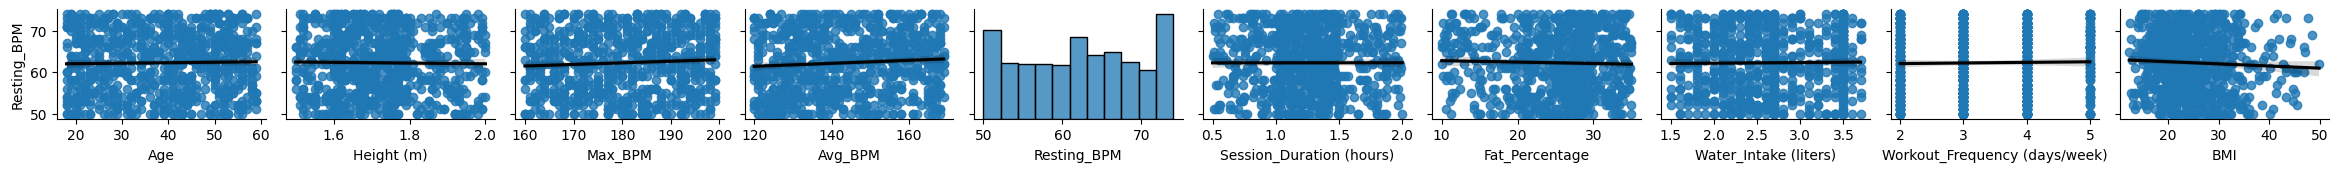

In [145]:
#Excluding one hot encoded data
sns.pairplot(df_train.loc[:,:'BMI'], kind='reg', y_vars='Resting_BPM', height=1.7, aspect=1.4, plot_kws={'line_kws': {'color':'black'}})

With the correlations as follows

In [152]:
np.round(df_train.corr().loc['Resting_BPM'],3)

Age                              0.019
Height (m)                      -0.015
Max_BPM                          0.060
Avg_BPM                          0.071
Resting_BPM                      1.000
Session_Duration (hours)         0.001
Fat_Percentage                  -0.028
Water_Intake (liters)            0.013
Workout_Frequency (days/week)    0.017
BMI                             -0.048
Gender_Female                   -0.006
Strength_Workout                 0.013
Cardio_Workout                  -0.012
Yoga_Workout                    -0.034
HIIT_Workout                     0.033
Name: Resting_BPM, dtype: float64

Surprisingly, Resting Heart Rate is extremely poorly correlated with any of this data! What about if we focused on subsections, such Female Gender, with a certain exercise type? Will we be able to find any significant relationship?

In [218]:
df_train.columns

Index(['Age', 'Height (m)', 'Max_BPM', 'Avg_BPM', 'Resting_BPM',
       'Session_Duration (hours)', 'Fat_Percentage', 'Water_Intake (liters)',
       'Workout_Frequency (days/week)', 'BMI', 'Gender_Female',
       'Strength_Workout', 'Cardio_Workout', 'Yoga_Workout', 'HIIT_Workout'],
      dtype='object')

#### Resting BPM vs all non-categorical data for Males that perform Strength Workouts:

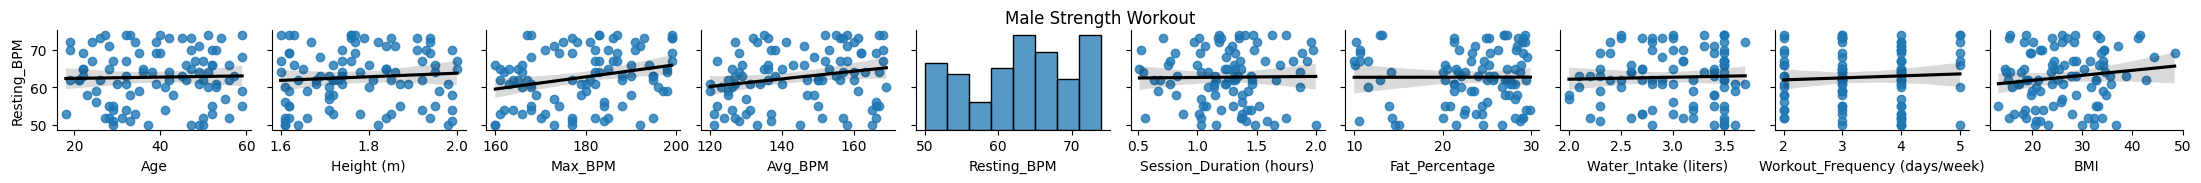

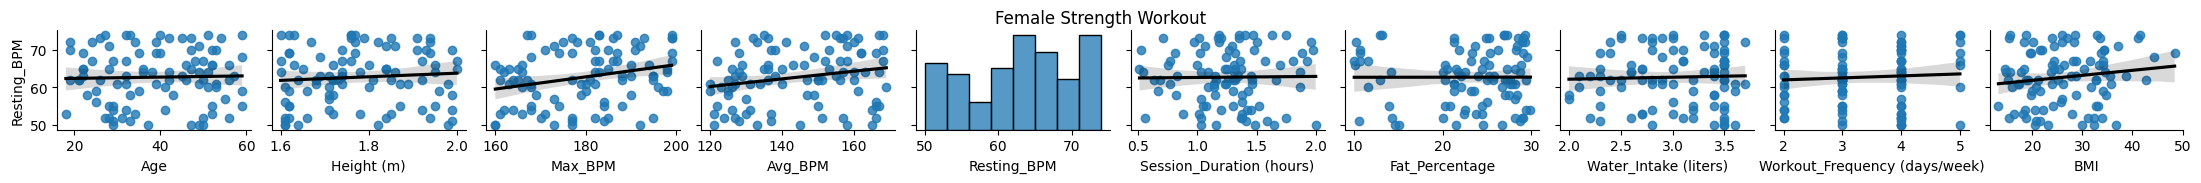

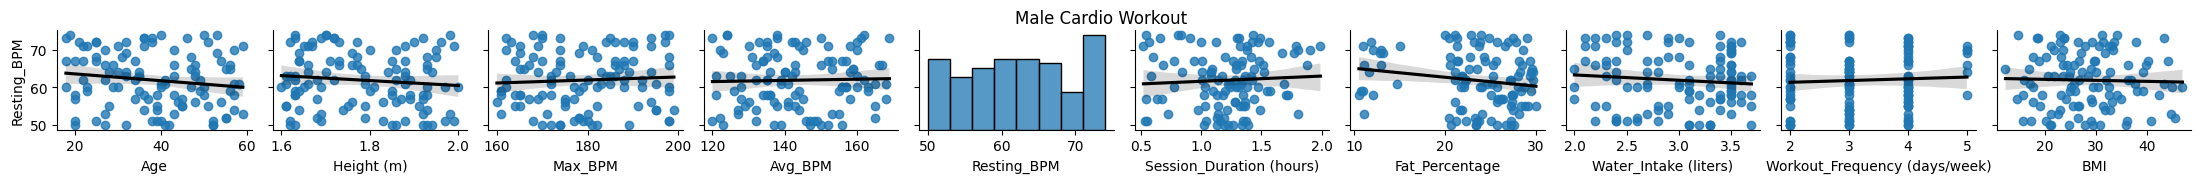

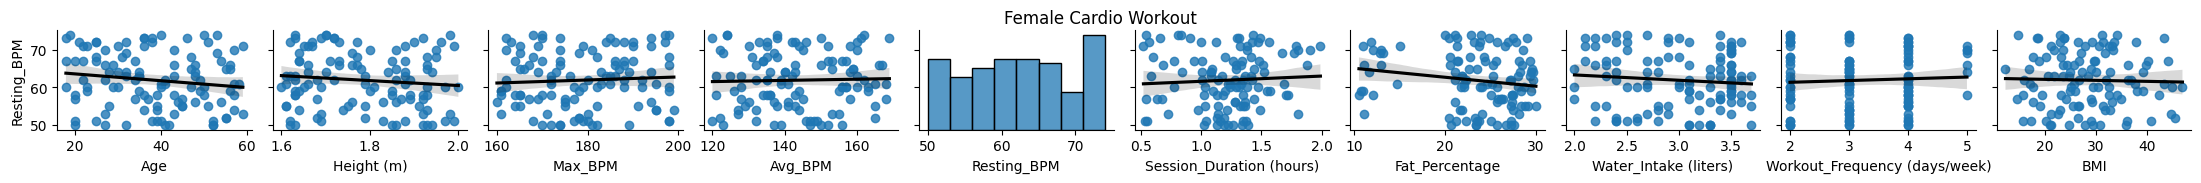

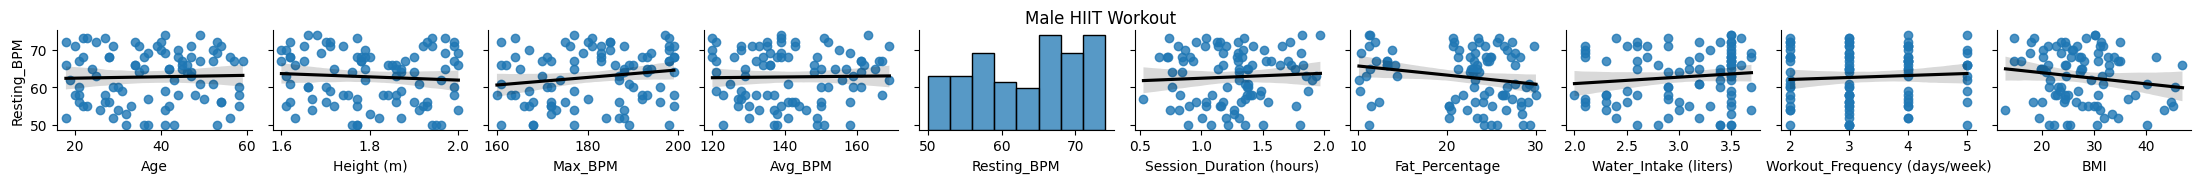

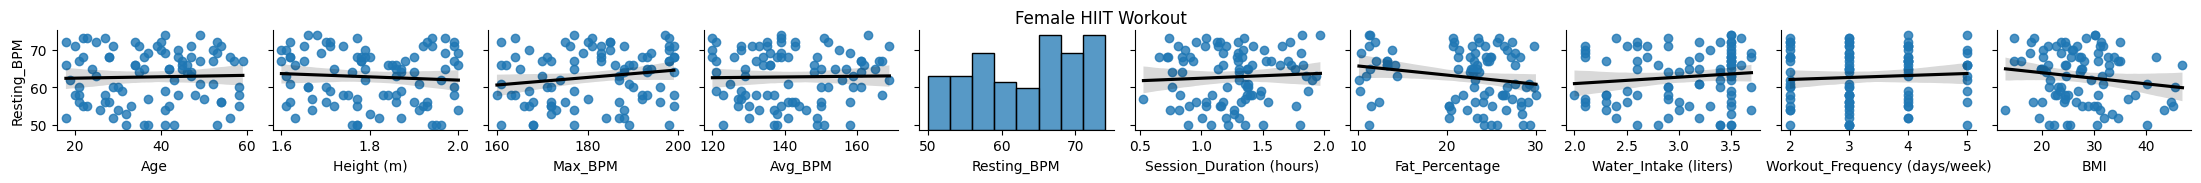

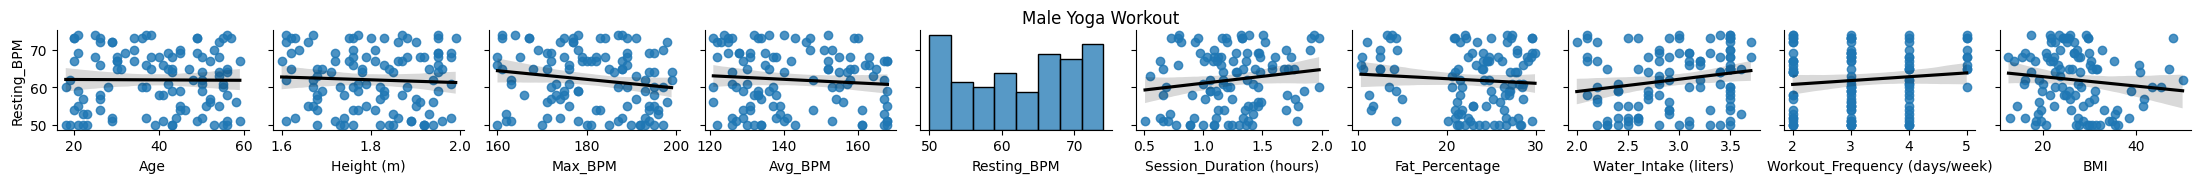

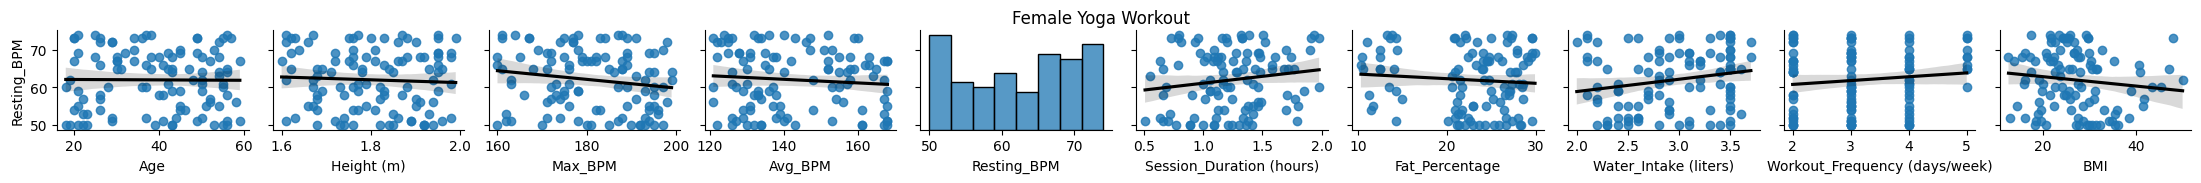

In [233]:
for workout, gender in list(itertools.product([workout for workout in ['Strength', 'Cardio', 'HIIT', 'Yoga']],[gender for gender in ['Male', 'Female']])):
    gender_female_int = 1 if gender ==1 else 0
    chart =sns.pairplot(df_train.query(f'Gender_Female == {gender_female_int} and {workout}_Workout==1').loc[:,:'BMI'], kind='reg', y_vars='Resting_BPM', height=1.6, aspect=1.4, plot_kws={'line_kws': {'color':'black'}})
    chart.fig.suptitle(f"{gender} {workout} Workout", y=1.078)

In [228]:
list(itertools.product([workout for workout in ['Strength', 'Cardio', 'HIIT', 'Yoga']],[gender for gender in ['Male', 'Female']]))

[('Strength', 'Male'),
 ('Strength', 'Female'),
 ('Cardio', 'Male'),
 ('Cardio', 'Female'),
 ('HIIT', 'Male'),
 ('HIIT', 'Female'),
 ('Yoga', 'Male'),
 ('Yoga', 'Female')]

Text(0.5, 1.078, 'Female Cardio Workout')

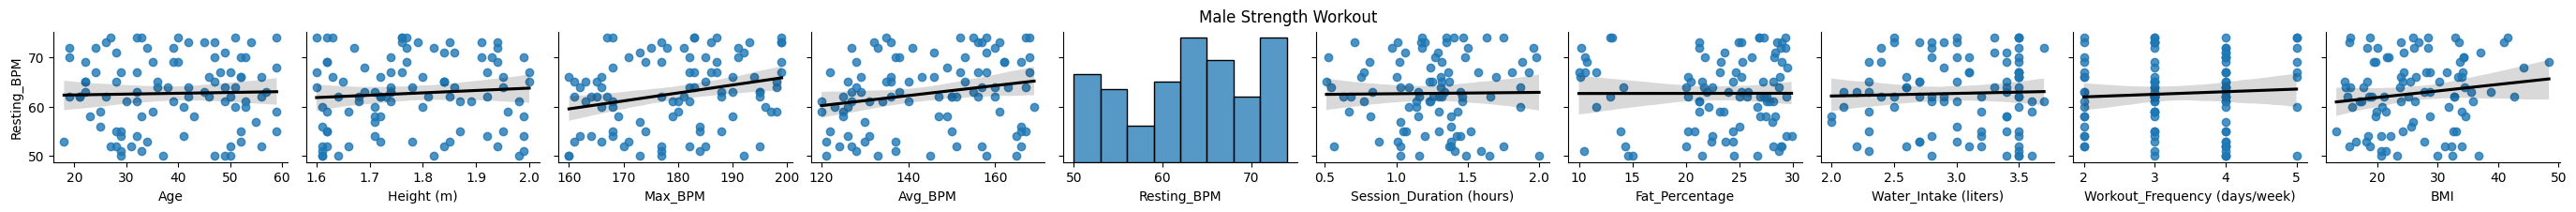

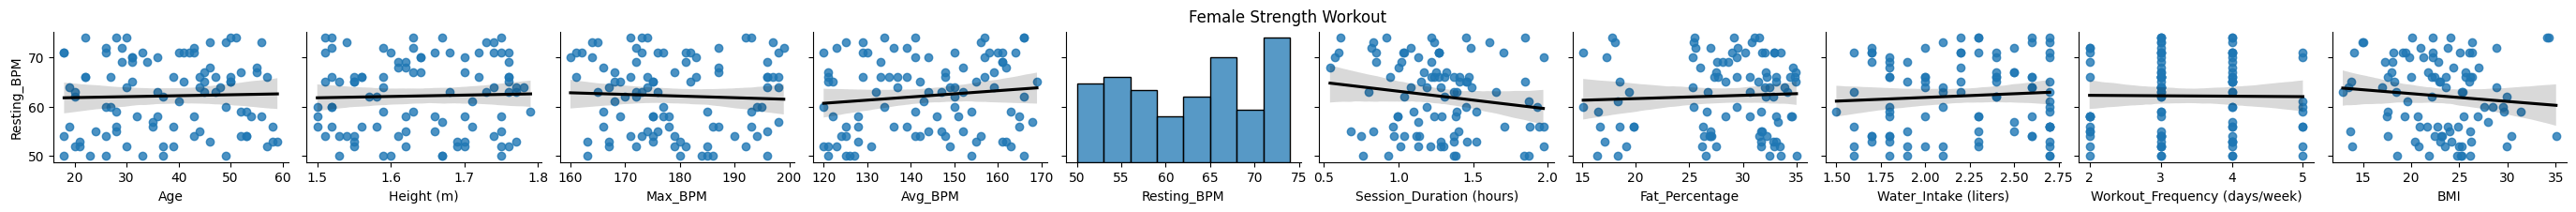

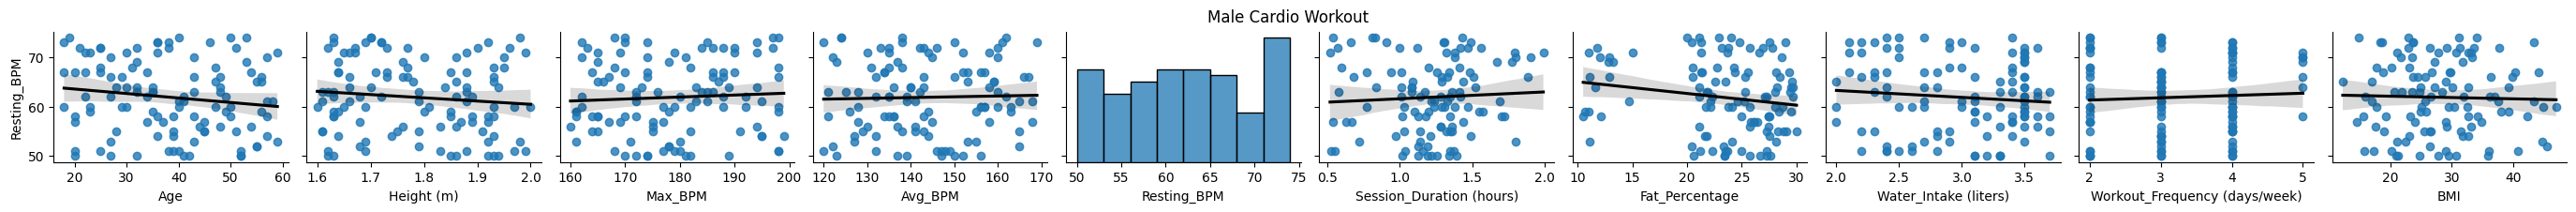

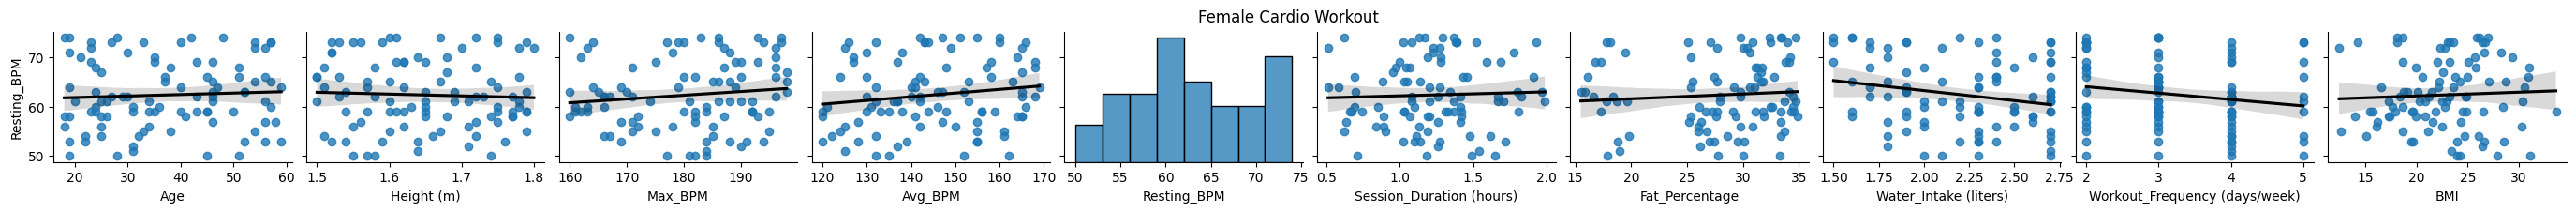

In [216]:
#fig, axes = plt.subplots(8,1, figsize=(19,10))
male_strength = sns.pairplot(df_train.query('Gender_Female == 0 and Strength_Workout==1').loc[:,:'BMI'], kind='reg', y_vars='Resting_BPM', height=2.0, aspect=1.4, plot_kws={'line_kws': {'color':'black'}})
male_strength.fig.suptitle("Male Strength Workout", y=1.078)
female_strength = sns.pairplot(df_train.query('Gender_Female == 1 and Strength_Workout==1').loc[:,:'BMI'], kind='reg', y_vars='Resting_BPM', height=2.0, aspect=1.4, plot_kws={'line_kws': {'color':'black'}})
female_strength.fig.suptitle("Female Strength Workout", y=1.078)

male_cardio_workout = sns.pairplot(df_train.query('Gender_Female == 0 and Cardio_Workout==1').loc[:,:'BMI'], kind='reg', y_vars='Resting_BPM', height=2.0, aspect=1.4, plot_kws={'line_kws': {'color':'black'}})
male_cardio_workout.fig.suptitle("Male Cardio Workout", y=1.078)
female_cardio_workout = sns.pairplot(df_train.query('Gender_Female == 1 and Cardio_Workout==1').loc[:,:'BMI'], kind='reg', y_vars='Resting_BPM', height=2.0, aspect=1.4, plot_kws={'line_kws': {'color':'black'}})
female_cardio_workout.fig.suptitle("Female Cardio Workout", y=1.078)

In [213]:
df_train.columns

Index(['Age', 'Height (m)', 'Max_BPM', 'Avg_BPM', 'Resting_BPM',
       'Session_Duration (hours)', 'Fat_Percentage', 'Water_Intake (liters)',
       'Workout_Frequency (days/week)', 'BMI', 'Gender_Female',
       'Strength_Workout', 'Cardio_Workout', 'Yoga_Workout', 'HIIT_Workout'],
      dtype='object')

#### Resting BPM vs all non-categorical data for Females that perform Strength Workouts:

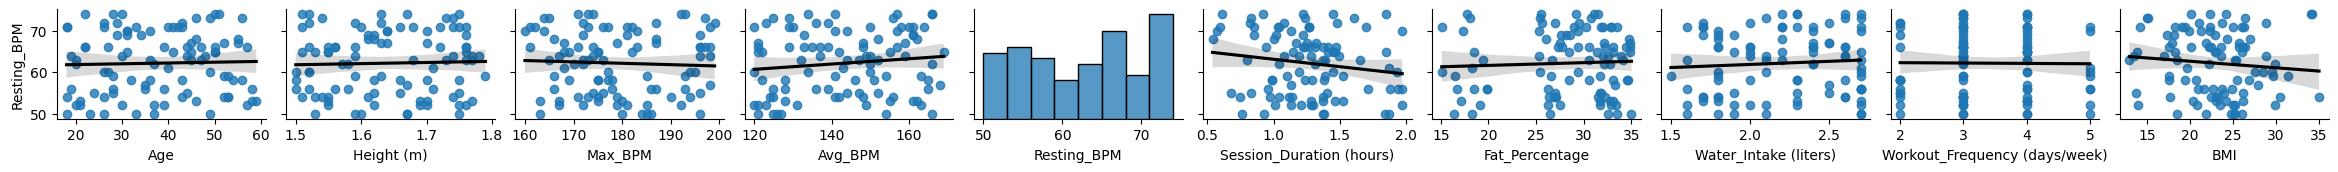

In [178]:
sns.pairplot(df_train.query('Gender_Female == 1 and Strength_Workout==1').loc[:,:'BMI'], kind='reg', y_vars='Resting_BPM', height=1.7, aspect=1.4, plot_kws={'line_kws': {'color':'black'}})

In [200]:
column_list = df_train.query('Gender_Female == 0 and Strength_Workout==1').loc[:,:'BMI']
df_train.query('Gender_Female == 0 and Strength_Workout==1').loc[:,:'BMI'].rename(columns = {[col: col+"x" for col in column_list]})

SyntaxError: invalid syntax (1597159108.py, line 2)

In [176]:
df_corr_all = pd.DataFrame(np.round(df_train.corr().loc['Resting_BPM'],3)).rename(columns={'Resting_BPM':"All"})
df_corr_all.index.name = 'Correlation to Resting_BPM'
df_male_strength = pd.DataFrame(np.round(df_train.query('Strength_Workout==1 and Gender_Female == 0').corr().loc['Resting_BPM'],3)).rename(columns={'Resting_BPM':"Male_Strength"})
pd.concat([df_corr_all, df_male_strength], axis = 1)

All  Male_Strength
Age                            0.019          0.027
Height (m)                    -0.015          0.082
Max_BPM                        0.060          0.263
Avg_BPM                        0.071          0.214
Resting_BPM                    1.000          1.000
Session_Duration (hours)       0.001          0.013
Fat_Percentage                -0.028          0.002
Water_Intake (liters)          0.013          0.034
Workout_Frequency (days/week)  0.017          0.064
BMI                           -0.048          0.142
Gender_Female                 -0.006            NaN
Strength_Workout               0.013            NaN
Cardio_Workout                -0.012            NaN
Yoga_Workout                  -0.034            NaN
HIIT_Workout                   0.033            NaN

# Creating a model and further analysis

# Data Cleaning

First, let's create a train and test set with 20%. Spark typically works with large datasets, so 20% would potentially be a valid size for our test set.

Let's apply Min-Max

In [31]:
cols_for_scaling = [col for col in df_final.columns if "_Workout" not in col and "Gender_" not in col]
assembler = VectorAssembler(inputCols= cols_for_scaling, outputCol='vector')
train_vectorized = assembler.transform(train_set)
test_vectorized = assembler.transform(test_set)

The output vector looks like:

In [32]:
train_vectorized.select(col('vector')).show(n=1)

+--------------------+
|              vector|
+--------------------+
|[18.0,50.7,1.53,1...|
+--------------------+
only showing top 1 row



24/12/07 14:33:45 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


Now create a scaled column based on the vector column

In [34]:
train_vectorized.show(n=3)

+---+-----------+----------+-------+-------+-----------+------------------------+---------------+--------------+---------------------+-----------------------------+----------------+-----+-------------+----------------+--------------+------------+------------+--------------------+
|Age|Weight (kg)|Height (m)|Max_BPM|Avg_BPM|Resting_BPM|Session_Duration (hours)|Calories_Burned|Fat_Percentage|Water_Intake (liters)|Workout_Frequency (days/week)|Experience_Level|  BMI|Gender_Female|Strength_Workout|Cardio_Workout|Yoga_Workout|HIIT_Workout|              vector|
+---+-----------+----------+-------+-------+-----------+------------------------+---------------+--------------+---------------------+-----------------------------+----------------+-----+-------------+----------------+--------------+------------+------------+--------------------+
| 18|       50.7|      1.53|    181|    147|         52|                    1.29|          948.0|          33.0|                  2.1|                       

In [54]:
scaler = StandardScaler(inputCol="vector",outputCol="scaled_vector", withMean=True, withStd=True)
scl = scaler.fit(train_vectorized)

#Now we create the scaled dataframe with OHE columns
train_scaled = scl.transform( train_vectorized).drop(col("vector"))

test_scaled = scl.transform( test_vectorized).drop("vector")

train_scaled.select(col("scaled_vector")).show(n=1)

+--------------------+
|       scaled_vector|
+--------------------+
|[-1.6889539663314...|
+--------------------+
only showing top 1 row



In [55]:
#train_scaled.withColumn("array", vector_to_array("scaled_vector")).withColumn("Age_scaled", col("v")[0]).show()

Let's turn our vector back into a format that would be easier to visualize via a dataframe. For each element in our vector, add it as a new dataframe column. Loop through the following columns using enumerate to get the vector location

In [56]:
cols_for_scaling

['Age',
 'Weight (kg)',
 'Height (m)',
 'Max_BPM',
 'Avg_BPM',
 'Resting_BPM',
 'Session_Duration (hours)',
 'Calories_Burned',
 'Fat_Percentage',
 'Water_Intake (liters)',
 'Workout_Frequency (days/week)',
 'Experience_Level',
 'BMI']

In [57]:
for n, column in enumerate(cols_for_scaling):
    train_scaled = train_scaled.withColumn("array", vector_to_array("scaled_vector")).withColumn(column, col("array")[n])#.show(n=3)
    test_scaled = test_scaled.withColumn("array", vector_to_array("scaled_vector")).withColumn(column, col("array")[n])

In [61]:
#df_final_scaled_unvectorized = df_final_scaled.withColumn("scaled_age", col("scaled_vector")[0])

In [58]:
test_scaled.show(n=5)

+------------------+--------------------+-------------------+-------------------+-------------------+--------------------+------------------------+-------------------+------------------+---------------------+-----------------------------+-------------------+--------------------+-------------+----------------+--------------+------------+------------+--------------------+--------------------+
|               Age|         Weight (kg)|         Height (m)|            Max_BPM|            Avg_BPM|         Resting_BPM|Session_Duration (hours)|    Calories_Burned|    Fat_Percentage|Water_Intake (liters)|Workout_Frequency (days/week)|   Experience_Level|                 BMI|Gender_Female|Strength_Workout|Cardio_Workout|Yoga_Workout|HIIT_Workout|       scaled_vector|               array|
+------------------+--------------------+-------------------+-------------------+-------------------+--------------------+------------------------+-------------------+------------------+---------------------+----

In [59]:
train_scaled.show(n=4)

+------------------+-------------------+--------------------+--------------------+------------------+-------------------+------------------------+-------------------+------------------+---------------------+-----------------------------+-------------------+--------------------+-------------+----------------+--------------+------------+------------+--------------------+--------------------+
|               Age|        Weight (kg)|          Height (m)|             Max_BPM|           Avg_BPM|        Resting_BPM|Session_Duration (hours)|    Calories_Burned|    Fat_Percentage|Water_Intake (liters)|Workout_Frequency (days/week)|   Experience_Level|                 BMI|Gender_Female|Strength_Workout|Cardio_Workout|Yoga_Workout|HIIT_Workout|       scaled_vector|               array|
+------------------+-------------------+--------------------+--------------------+------------------+-------------------+------------------------+-------------------+------------------+---------------------+-------

Now our data has scaled data covering BMI, etc. as well as One Hot Encoded data such as Gender_Female and workout type, as well as the vector and array versions of this.

# Data Exploration Xd

Let's view the relationship between resting BPM and BMI. We will convert our data to a Pandas dataframe, which is not advisable when working with large data. However, in this case, we will simply show off some of the Spark functionality.

In [64]:
train_scaled.show(n=4)

+------------------+-------------------+--------------------+--------------------+------------------+-------------------+------------------------+-------------------+------------------+---------------------+-----------------------------+-------------------+--------------------+-------------+----------------+--------------+------------+------------+--------------------+--------------------+
|               Age|        Weight (kg)|          Height (m)|             Max_BPM|           Avg_BPM|        Resting_BPM|Session_Duration (hours)|    Calories_Burned|    Fat_Percentage|Water_Intake (liters)|Workout_Frequency (days/week)|   Experience_Level|                 BMI|Gender_Female|Strength_Workout|Cardio_Workout|Yoga_Workout|HIIT_Workout|       scaled_vector|               array|
+------------------+-------------------+--------------------+--------------------+------------------+-------------------+------------------------+-------------------+------------------+---------------------+-------

Correlation is not dependent on scale, so we will proceed

In [75]:

non_vector_columns = [col for col in train_scaled.columns if col not in ['array', 'scaled_vector']]
train_pandas = train_scaled.select([col(column) for column in non_vector_columns]).toPandas()

## Correlation Heatmap

In [90]:
#Subset of data to highlight column
train_pandas.iloc[:,10:-2].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 762 entries, 0 to 761
Data columns (total 6 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Workout_Frequency (days/week)  762 non-null    float64
 1   Experience_Level               762 non-null    float64
 2   BMI                            762 non-null    float64
 3   Gender_Female                  762 non-null    float64
 4   Strength_Workout               762 non-null    int32  
 5   Cardio_Workout                 762 non-null    int32  
dtypes: float64(4), int32(2)
memory usage: 29.9 KB


The workout columns are of type Integer, so let's transform them

<Figure size 2000x1000 with 0 Axes>

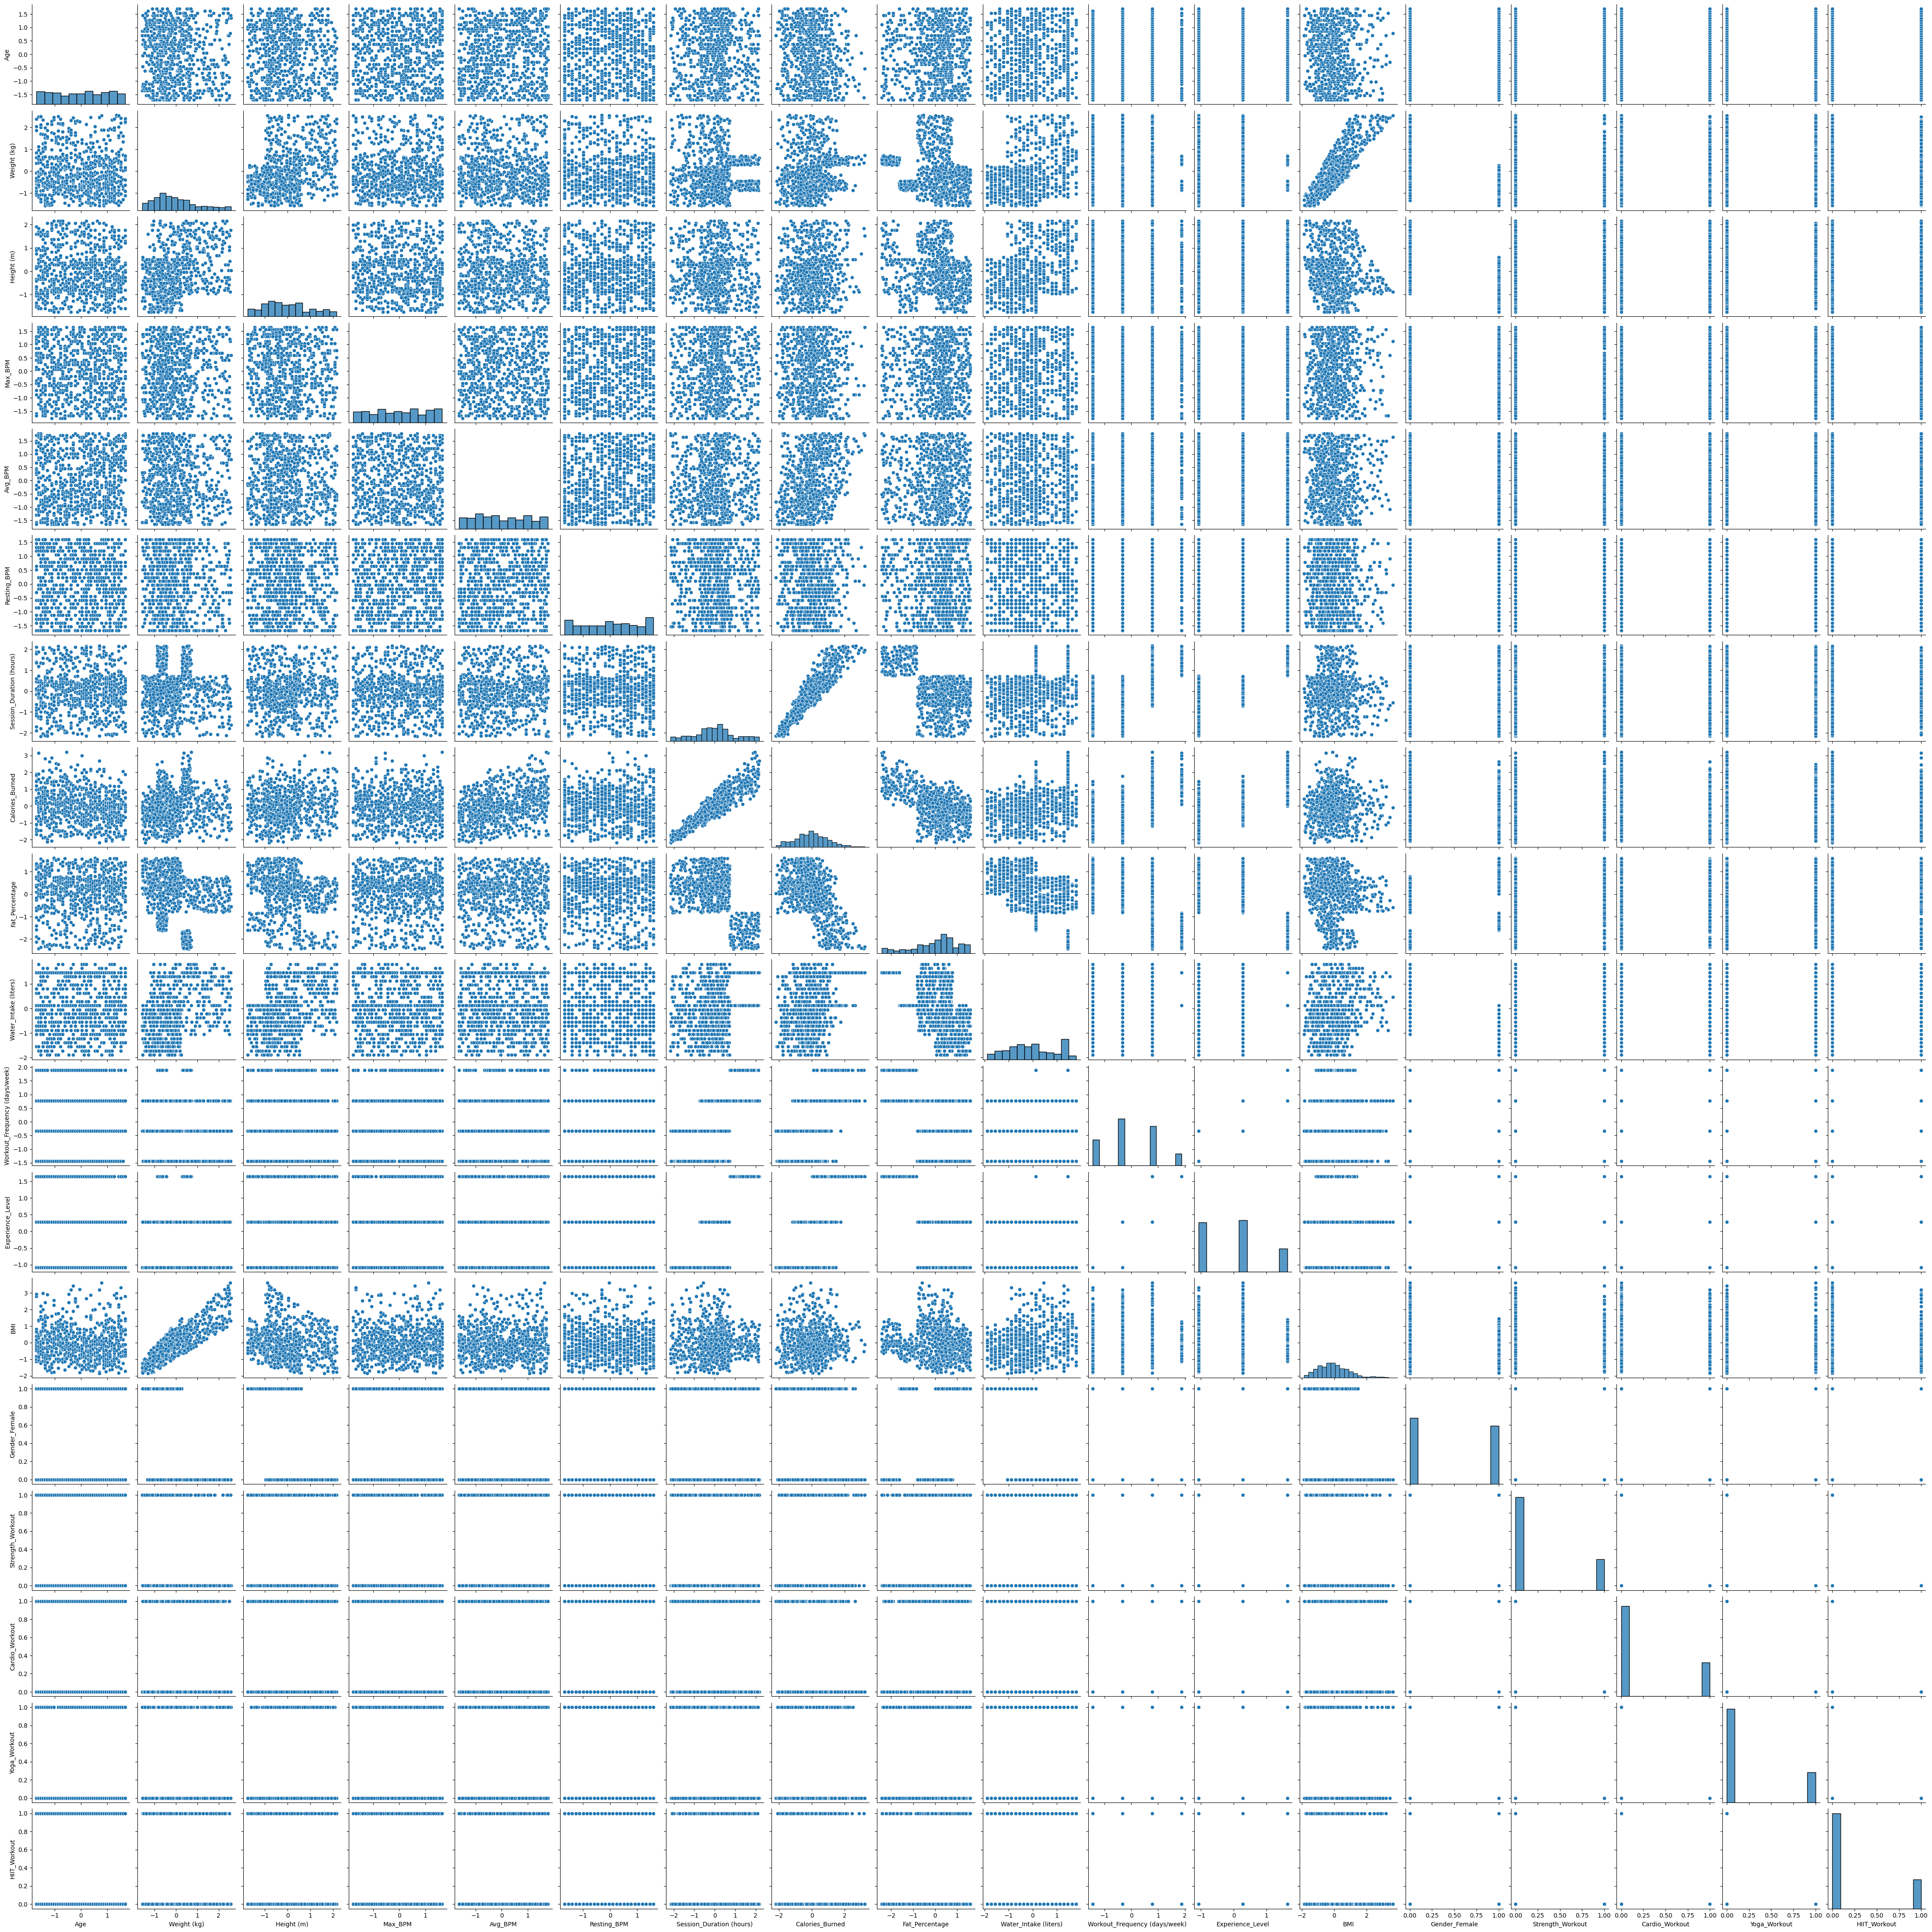

In [96]:
plt.figure(figsize=(20,10))
sns.pairplot(train_pandas)

In [85]:
train_pandas.columns

Index(['Age', 'Weight (kg)', 'Height (m)', 'Max_BPM', 'Avg_BPM', 'Resting_BPM',
       'Session_Duration (hours)', 'Calories_Burned', 'Fat_Percentage',
       'Water_Intake (liters)', 'Workout_Frequency (days/week)',
       'Experience_Level', 'BMI', 'Gender_Female', 'Strength_Workout',
       'Cardio_Workout', 'Yoga_Workout', 'HIIT_Workout'],
      dtype='object')

In [9]:
df_bpm_bmi.c

NameError: name 'df_bpm_bmi' is not defined

AttributeError: Rectangle.set() got an unexpected keyword argument 'hist'

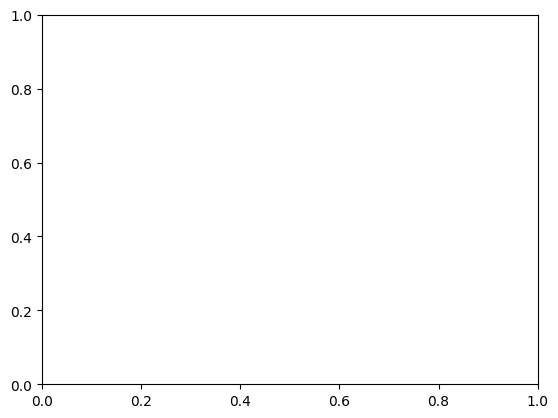

In [68]:
#Let's check the distribution
sns.histplot(train_bpm_bmi['Resting_BPM'], color="red", hist=True, rug=True, label='Resting BPM')
sns.histplot(train_bpm_bmi['BMI'], color="green", hist=True, rug=True, label='BMI')
plt.legend()
plt.xlabel('Value')
plt.ylabel('Density')
plt.title('Dist. BPM and BMI')
plt.show()

In [121]:

#assembler = VectorAssembler(inputCols=['Workout_Type'], outputCol='output_Workout')
#assembler.transform(df_transformed).withColumn("x", col("output_Workout").cast("String")).show()
#df_transformed.withColumn("Workout_Type_0", col("Workout_Type").getItem(0)).show()

In [31]:
#indexer = model.stages[1]
#[z for z in enumerate(indexer.labels) ]

[(0, 'Strength'), (1, 'Cardio'), (2, 'Yoga'), (3, 'HIIT')]

In [60]:
#def add_workout_type_columns(df, indexer):
#    label_list= indexer.labels
    

In [38]:
for i in range(0,2):
    #Let's get both string indexers from our trained pipeline
    model_indexer = model.stages[0]
    label_list = model_indexer.labels
    #This is not the most elegant process as Gender and Workout_Type are represented in two different formats. But it represents different methods of working with our data. 
    if i == 0:
        for gender, index in list(zip())
        df_transformed.withColumn("Gender", col(""))
    

0
1


In [29]:
df_transformed.toPandas().iloc[:,:4].corr()

Age  Weight (kg)  Height (m)   Max_BPM
Age          1.000000    -0.036340   -0.027837 -0.017073
Weight (kg) -0.036340     1.000000    0.365321  0.057061
Height (m)  -0.027837     0.365321    1.000000 -0.017660
Max_BPM     -0.017073     0.057061   -0.017660  1.000000

### Goal
From first glance, it appears that Workout_Type and Gender should be one-hot encoded.
The greatest measure of health in my opinion is Resting Heart rate, so let's build a model that attempts to solve for it.

## Sample Streaming Process

In [100]:
#Howerver, let's assume we're working with a dynamic stream. In this case, we choose to append, assuming new additions may be added
schema = StructType( [
    StructField("Age", IntegerType(), True),                StructField("Gender", StringType(), True),
    StructField("Weight_(kg)", FloatType(), True),          StructField("Height_(m)", FloatType(), True),
    StructField("Max_BPM", IntegerType(), True),            StructField("Avg_BPM", IntegerType(), True),
    StructField("Resting_BPM", IntegerType(), True),        StructField("Session_Duration_(hours)", FloatType(), True), 
    StructField("Calories_Burned", FloatType(), True),      StructField("Workout_Type", StringType(), True),
    StructField("Fat_Percentage", FloatType(), True),       StructField("Water_Intake_(liters)", FloatType(), True),
    StructField("Workout_Frequency_(days/week)", IntegerType(), True),
    StructField("Experience_Level", IntegerType(), True),   StructField("BMI", FloatType(), True)
])

df = spark.readStream.schema(schema).csv("health_data")

### Let's view by batch:

Although our streaming directory has two separate data files, the stream consolidates them into one.

In [85]:
def show_head_and_shape(batch_df, batch_id):
    print("2")
    print(f"batch {batch_id} has {batch_df.count()} rows")
    batch_df.show(n=1)
    print("\n")

query = df.writeStream.foreachBatch(show_head_and_shape).start()

One Hot Encoding the inputs. As discussed, Gender and Workout Type should be one hot encoded. To do this, we initially have to apply a StringIndexer as OHE in this case needs to work with numerical values

In [101]:

indexer_gender = StringIndexer(inputCol = "Gender", outputCol="Gender_Index")
ohe_gender = OneHotEncoder(inputCol = "Gender_Index", outputCol = "Gender_Encoded")
pipeline = Pipeline(stages=[indexer_gender, ohe_gender])
#model = pipeline.fit(df)
#
df = indexer.fit(df).transform(df)

AnalysisException: Queries with streaming sources must be executed with writeStream.start();
FileSource[health_data]

In [99]:
df.show()

+---+------+-----------+----------+-------+-------+-----------+------------------------+---------------+------------+--------------+---------------------+-----------------------------+----------------+-----+------------+
|Age|Gender|Weight (kg)|Height (m)|Max_BPM|Avg_BPM|Resting_BPM|Session_Duration (hours)|Calories_Burned|Workout_Type|Fat_Percentage|Water_Intake (liters)|Workout_Frequency (days/week)|Experience_Level|  BMI|Gender_Index|
+---+------+-----------+----------+-------+-------+-----------+------------------------+---------------+------------+--------------+---------------------+-----------------------------+----------------+-----+------------+
| 56|  Male|       88.3|      1.71|    180|    157|         60|                    1.69|         1313.0|        Yoga|          12.6|                  3.5|                            4|               3| 30.2|         0.0|
| 46|Female|       74.9|      1.53|    179|    151|         66|                     1.3|          883.0|        HIIT

In [81]:
#Show first rows
query = df.writeStream.outputMode("append").format("console").start()

-------------------------------------------
Batch: 0
-------------------------------------------
+---+------+-----------+----------+-------+-------+-----------+------------------------+---------------+------------+--------------+---------------------+-----------------------------+----------------+-----+
|Age|Gender|Weight_(kg)|Height_(m)|Max_BPM|Avg_BPM|Resting_BPM|Session_Duration_(hours)|Calories_Burned|Workout_Type|Fat_Percentage|Water_Intake_(liters)|Workout_Frequency_(days/week)|Experience_Level|  BMI|
+---+------+-----------+----------+-------+-------+-----------+------------------------+---------------+------------+--------------+---------------------+-----------------------------+----------------+-----+
| 56|  Male|       88.3|      1.71|    180|    157|         60|                    1.69|         1313.0|        Yoga|          12.6|                  3.5|                            4|               3| 30.2|
| 46|Female|       74.9|      1.53|    179|    151|         66|        

In [45]:
df.count()

AnalysisException: Queries with streaming sources must be executed with writeStream.start();
FileSource[health_data]

In [7]:
df.printSchema()

root
 |-- Age: string (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Weight (kg): string (nullable = true)
 |-- Height (m): string (nullable = true)
 |-- Max_BPM: string (nullable = true)
 |-- Avg_BPM: string (nullable = true)
 |-- Resting_BPM: string (nullable = true)
 |-- Session_Duration (hours): string (nullable = true)
 |-- Calories_Burned: string (nullable = true)
 |-- Workout_Type: string (nullable = true)
 |-- Fat_Percentage: string (nullable = true)
 |-- Water_Intake (liters): string (nullable = true)
 |-- Workout_Frequency (days/week): string (nullable = true)
 |-- Experience_Level: string (nullable = true)
 |-- BMI: string (nullable = true)



# Overview

In [31]:
[x for x in [1,2,4]]+ [x for x in [4,5,6]]

[1, 2, 4, 4, 5, 6]

In [33]:
[ StructField(col, StringType(), True) for col in string_columns ] + [ StructField(col, IntegerType(), True) for col in columns if col not in string_columns]

[StructField('Workout_Type', StringType(), True),
 StructField('Gender', StringType(), True),
 StructField('Age', IntegerType(), True),
 StructField('Weight (kg)', IntegerType(), True),
 StructField('Height (m)', IntegerType(), True),
 StructField('Max_BPM', IntegerType(), True),
 StructField('Avg_BPM', IntegerType(), True),
 StructField('Resting_BPM', IntegerType(), True),
 StructField('Session_Duration (hours)', IntegerType(), True),
 StructField('Calories_Burned', IntegerType(), True),
 StructField('Fat_Percentage', IntegerType(), True),
 StructField('Water_Intake (liters)', IntegerType(), True),
 StructField('Workout_Frequency (days/week)', IntegerType(), True),
 StructField('Experience_Level', IntegerType(), True),
 StructField('BMI', IntegerType(), True)]

In [43]:
#Make into ints/strings
"""
columns = df.columns
string_columns = ['Workout_Type', 'Gender']
schema = StructType(
    [ StructField(col, StringType(), True) for col in string_columns ] + [ StructField(col, IntegerType(), True) for col in columns if col not in string_columns]
)
"""

"\ncolumns = df.columns\nstring_columns = ['Workout_Type', 'Gender']\nschema = StructType(\n    [ StructField(col, StringType(), True) for col in string_columns ] + [ StructField(col, IntegerType(), True) for col in columns if col not in string_columns]\n)\n"

Count NULLs. There are none.

In [13]:
df.select([count( when( isnan(c), c)).alias(c) for c in df.columns]).show()

+---+------+-----------+----------+-------+-------+-----------+------------------------+---------------+------------+--------------+---------------------+-----------------------------+----------------+---+
|Age|Gender|Weight (kg)|Height (m)|Max_BPM|Avg_BPM|Resting_BPM|Session_Duration (hours)|Calories_Burned|Workout_Type|Fat_Percentage|Water_Intake (liters)|Workout_Frequency (days/week)|Experience_Level|BMI|
+---+------+-----------+----------+-------+-------+-----------+------------------------+---------------+------------+--------------+---------------------+-----------------------------+----------------+---+
|  0|     0|          0|         0|      0|      0|          0|                       0|              0|           0|             0|                    0|                            0|               0|  0|
+---+------+-----------+----------+-------+-------+-----------+------------------------+---------------+------------+--------------+---------------------+----------------------

In [22]:
#Save table to catalog
df.write.saveAsTable("health_data")
#Read catalog 
print(spark.catalog.listTables())

[Table(name='health_data', catalog='spark_catalog', namespace=['default'], description=None, tableType='MANAGED', isTemporary=False)]


In [28]:
temp_df = spark.sql("select _c1, _c2 from health_data limit 3")

In [ ]:
# Count the number of nulls in each column of the dataframe
df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns]).show()

In [25]:
#df.select("Age", "Weight (kg)", "Height (m)").show()
#df.groupBy("Age").count().show()
df.filter(df["Age"]==47).show()

+---+------+-----------+----------+-------+-------+-----------+------------------------+---------------+------------+--------------+---------------------+-----------------------------+----------------+-----+
|Age|Gender|Weight (kg)|Height (m)|Max_BPM|Avg_BPM|Resting_BPM|Session_Duration (hours)|Calories_Burned|Workout_Type|Fat_Percentage|Water_Intake (liters)|Workout_Frequency (days/week)|Experience_Level|  BMI|
+---+------+-----------+----------+-------+-------+-----------+------------------------+---------------+------------+--------------+---------------------+-----------------------------+----------------+-----+
| 47|Female|       66.8|      1.75|    199|    146|         56|                    1.13|          742.0|    Strength|          32.8|                  2.5|                            3|               2|21.81|
| 47|Female|       58.5|      1.79|    195|    131|         71|                    1.42|          837.0|        Yoga|          30.3|                  2.4|              

As one can see, the columns are set arbitrarily.
Instead, we want to set the first row to the column names

In [30]:
temp_df.toPandas()

_c1          _c2
0  Gender  Weight (kg)
1    Male         88.3
2  Female         74.9

24/11/19 02:18:27 WARN HeartbeatReceiver: Removing executor driver with no recent heartbeats: 911560 ms exceeds timeout 120000 ms
24/11/19 02:18:27 WARN SparkContext: Killing executors is not supported by current scheduler.
24/11/19 02:18:34 WARN Executor: Issue communicating with driver in heartbeater
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:101)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:85)
	at org.apache.spark.storage.BlockManagerMaster.registerBlockManager(BlockManagerMaster.scala:80)
	at org.apache.spark.storage.BlockManager.reregister(BlockManager.scala:641)
	at org.apache.spark.executor.Executor.reportHeartBeat(Executor.scala:1111)
	at org.apache.spark.executor.Executor.$anonfun$heartbeater$1(Executor.scala:244)
	at sc

In [13]:
row_1 = df.collect()[0]

In [14]:
row_1

Row(_c0='Age', _c1='Gender', _c2='Weight (kg)', _c3='Height (m)', _c4='Max_BPM', _c5='Avg_BPM', _c6='Resting_BPM', _c7='Session_Duration (hours)', _c8='Calories_Burned', _c9='Workout_Type', _c10='Fat_Percentage', _c11='Water_Intake (liters)', _c12='Workout_Frequency (days/week)', _c13='Experience_Level', _c14='BMI')